# Replicate paper with ShenZhen Stock Exchange data

In [1]:
import os, pandas as pd
from sqlalchemy import create_engine, Column, MetaData, text, engine
import getpass, datetime, time
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
user = getpass.getpass()
password = getpass.getpass()

········
········


In [3]:
def mysql_query(query,user=user, password=password, host='localhost', port=3306):
    # check if port is in 9030, 19030, or 3306, 9005
    # start time
    start_time = time.time()
    
    if port in [3306]:
        engine = create_engine('mysql+pymysql://'+user+':'+password+'@'+host+':'+str(port))
        df = pd.read_sql_query(sql=text(query), con=engine.connect())
        # end time
        end_time = time.time()
        # seconds
        elapsed_time = end_time - start_time
        print(f'Elapsed time: {elapsed_time} seconds')
        return df    
    else:
        print('port is not in 3306, please check')
        return None

# Define some functions to do regression and plotting dataframes.

In [5]:
round_sig = lambda f,p: str(('%.' + str(p) + 'e') % float(f))
sig_num = 2

def regression_res(formula, data, name, exhibit = True):
    fit = smf.ols(formula, data = data).fit()
    if exhibit:
        res = fit.params.astype(str)
        for i in range(res.shape[0]):
            if fit.pvalues.iloc[i] < 0.01:
                res.iloc[i] = round_sig(res.iloc[i], sig_num) + "***"
            elif fit.pvalues.iloc[i] < 0.05:
                res.iloc[i] = round_sig(res.iloc[i], sig_num) + "**"
            elif fit.pvalues.iloc[i] < 0.10:
                res.iloc[i] = round_sig(res.iloc[i], sig_num) + "*"
            else:
                res.iloc[i] = round_sig(res.iloc[i], sig_num) + ""
            res.iloc[i] += "(%s)" % round_sig(str(fit.HC0_se.iloc[i]), sig_num)
        res['num of obs'] = int(fit.nobs)
        res['adj. R sq.'] = fit.rsquared_adj
    else:
        res = fit.params
    res.name = name
    return res

In [6]:
def plot_df(df, title):
    return df.style.set_caption(
        title
    ).set_table_styles(
        [
            {'selector': 'caption', 
             'props': 'caption-side: top; font-size: 2em; text-align: center;'
            }
        ], 
        overwrite=False
    )

# Replicate table 1

In [7]:
query = """ select 
                year(date_time) as `year`, 
                count(tic) as `Num of stocks`, 
                avg(totalCapital) as avg_AUM 
            from 7035_prj.sz_trading_data
            group by year(date_time) 
            order by year(date_time) """
df1 = mysql_query(query,user=user,password=password,port=3306)

Elapsed time: 8.312730312347412 seconds


In [8]:
df1.head()

,year,Num of stocks,avg_AUM
0,2014,2704,9.774363e+09
1,2015,228681,1.417150e+10
2,2016,238442,1.379028e+10
3,2017,261452,1.432278e+10
4,2018,276339,1.254548e+10


In [9]:
df1.to_parquet('table1_descriptiveStat.parquet')

In [10]:
query = """ select 
                `year`, AVG(`FIT`) AS `avg_FIT`, `decile`
            from
                (select 
                    year(date_time) as `year`, `FIT`,
                    CEILING(ROW_NUMBER() OVER (PARTITION BY YEAR(`date_time`) ORDER BY `FIT` asc) / COUNT(*) OVER (PARTITION BY YEAR(`date_time`)) * 3) AS decile
                from
                    (select
                        date_time, tic,
                        lag_totalShares * money / lag_sum_totalShares as `FIT`
                    from
                        (select 
                            date_time, tic, money, 
                            lag(totalShares) over (partition by `tic` order by date_time) as lag_totalShares
                        from 7035_prj.sz_trading_data) a
                        join
                        (select
                            `year`, sum(lag_totalShares) as lag_sum_totalShares
                        from
                            (select 
                                year(date_time) as `year`, 
                                lag(totalShares) over (partition by `tic` order by date_time asc) as lag_totalShares
                            from 
                                7035_prj.sz_trading_data
                            ) b_
                        group by `year`
                        ) b
                        on b.`year` = year(a.date_time)
                    where lag_totalShares is not null and lag_sum_totalShares is not null
                    ) c
                ) d
            GROUP BY `year`, `decile`
            ORDER BY `year`, `decile`; """
df2 = mysql_query(query,user=user,password=password,port=3306)

Elapsed time: 206.37497115135193 seconds


In [11]:
df2.head()

,year,avg_FIT,decile
0,2014,3503.511008,1.0
1,2014,20767.711104,2.0
2,2014,938233.855541,3.0
3,2015,61.691083,1.0
4,2015,478.445838,2.0


In [12]:
df2.to_parquet('table1_FITDeciles.parquet')

In [13]:
df1 = pd.read_parquet('table1_descriptiveStat.parquet')
df2 = pd.read_parquet('table1_FITDeciles.parquet')
plot_df(df1
        .set_index('year')
        .merge(df2.pivot(index = 'year', columns = 'decile', values = 'avg_FIT'
                        ).rename(columns = lambda x: 'FIT_decile_%s' %x),
               left_index = True, right_index = True),
        'Table 1'
       )

,Num of stocks,avg_AUM,FIT_decile_1.0,FIT_decile_2.0,FIT_decile_3.0
year,,,,,
2014,2704,9774362818.047337,3503.511008,20767.711104,938233.855541
2015,228681,14171501213.349600,61.691083,478.445838,10153.282230
2016,238442,13790283653.077059,68.204455,293.963148,3273.971147
2017,261452,14322781282.560471,32.784505,164.279295,3768.565727
2018,276339,12545479978.207926,18.755661,103.244750,2855.281026
2019,287160,13246488234.047220,27.027236,147.056282,3707.106066
2020,296368,18038044123.312908,38.549958,231.866565,5594.865935
2021,311086,22852390183.878414,33.530826,223.910787,6312.415541
2022,320942,20053049949.984734,41.803710,221.023200,3970.081983


# Replicate table 2

In [62]:
query = """ 
select
    *
from
    (SELECT 
        date_time, tic, 
        totalCapital / lag_totalCapital - 1 AS `ret`,
        money as flow,
        lag(money, 1) over (partition by tic order by date_time asc) as flow_lag1,
        lag(money, 2) over (partition by tic order by date_time asc) as flow_lag2,
        lag(money, 3) over (partition by tic order by date_time asc) as flow_lag3,
        lag(money, 4) over (partition by tic order by date_time asc) as flow_lag4,
        lag(money, 5) over (partition by tic order by date_time asc) as flow_lag5,
        lag(money, 6) over (partition by tic order by date_time asc) as flow_lag6,
        lag(money, 7) over (partition by tic order by date_time asc) as flow_lag7,
        lag(money, 8) over (partition by tic order by date_time asc) as flow_lag8,
        lag(money, 9) over (partition by tic order by date_time asc) as flow_lag9,
        lag(money, 10) over (partition by tic order by date_time asc) as flow_lag10,
        lag(money, 11) over (partition by tic order by date_time asc) as flow_lag11,
        lag(money, 12) over (partition by tic order by date_time asc) as flow_lag12
    FROM 
        (SELECT date_time, tic, money, totalCapital, LAG(totalCapital) over (PARTITION BY tic ORDER BY date_time asc) AS lag_totalCapital,
         %s
         FROM 7035_prj.sz_trading_data
        ) a
    where lag_totalCapital is not null %s
    ) b
where flow_lag1 is not null and flow_lag2 is not null and flow_lag3 is not null and flow_lag4 is not null and flow_lag5 is not null and flow_lag6 is not null and flow_lag7 is not null and flow_lag8 is not null and flow_lag9 is not null and flow_lag10 is not null and flow_lag11 is not null and flow_lag12 IS NOT null
"""

### Both factors

In [63]:
deciles = """ CEILING(ROW_NUMBER() OVER (PARTITION BY year(`date_time`), month(`date_time`) ORDER BY pe_ttm / ps asc) / COUNT(*) OVER (PARTITION BY year(`date_time`), month(`date_time`)) * 10) AS profitability_decile,
              CEILING(ROW_NUMBER() OVER (PARTITION BY year(`date_time`), month(`date_time`) ORDER BY pb asc) / COUNT(*) OVER (PARTITION BY year(`date_time`), month(`date_time`)) * 10) AS value_decile """
filters = """ and profitability_decile = 10 and value_decile = 10 """

df = mysql_query(query % (deciles, filters),
                 user=user,
                 password=password,
                 port=3306)
df.to_parquet('table2_bothFactors.parquet')

Elapsed time: 742.6782581806183 seconds


In [64]:
df.head()

,date_time,tic,ret,flow,flow_lag1,flow_lag2,flow_lag3,flow_lag4,flow_lag5,flow_lag6,flow_lag7,flow_lag8,flow_lag9,flow_lag10,flow_lag11,flow_lag12
0,2015-10-23,000017_SZ\r,0.088853,364011000.0,235533000.0,283476000.0,243305000.0,300598000.0,191377000.0,134296000.0,155178000.0,134689000.0,174710000.0,109355000.0,61518300.0,28271800.0
1,2015-10-26,000017_SZ\r,-0.027750,280919000.0,364011000.0,235533000.0,283476000.0,243305000.0,300598000.0,191377000.0,134296000.0,155178000.0,134689000.0,174710000.0,109355000.0,61518300.0
2,2015-10-27,000017_SZ\r,-0.012331,166773000.0,280919000.0,364011000.0,235533000.0,283476000.0,243305000.0,300598000.0,191377000.0,134296000.0,155178000.0,134689000.0,174710000.0,109355000.0
3,2015-10-28,000017_SZ\r,-0.020891,153167000.0,166773000.0,280919000.0,364011000.0,235533000.0,283476000.0,243305000.0,300598000.0,191377000.0,134296000.0,155178000.0,134689000.0,174710000.0
4,2015-10-29,000017_SZ\r,0.088401,294083000.0,153167000.0,166773000.0,280919000.0,364011000.0,235533000.0,283476000.0,243305000.0,300598000.0,191377000.0,134296000.0,155178000.0,134689000.0


### profitability factor: PE ratio / PS ratio

In [65]:
deciles = """CEILING(ROW_NUMBER() OVER (PARTITION BY year(`date_time`), month(`date_time`) ORDER BY pe_ttm / ps asc) / COUNT(*) OVER (PARTITION BY year(`date_time`), month(`date_time`)) * 10) AS profitability_decile"""
filters = """and profitability_decile = 10"""

df = mysql_query(query % (deciles, filters),
                 user=user,
                 password=password,
                 port=3306)
df.to_parquet('table2_profitabilityFactors.parquet')

Elapsed time: 644.4036920070648 seconds


In [66]:
df.head()

,date_time,tic,ret,flow,flow_lag1,flow_lag2,flow_lag3,flow_lag4,flow_lag5,flow_lag6,flow_lag7,flow_lag8,flow_lag9,flow_lag10,flow_lag11,flow_lag12
0,2018-01-18,000009_SZ\r,0.001466,97271800.0,136085000.0,155178000.0,267350000.0,161188000.0,407941000.0,137333000.0,123617000.0,178511000.0,196259000.0,358090000.0,170637000.0,140498000.0
1,2018-01-19,000009_SZ\r,-0.002935,87231700.0,97271800.0,136085000.0,155178000.0,267350000.0,161188000.0,407941000.0,137333000.0,123617000.0,178511000.0,196259000.0,358090000.0,170637000.0
2,2018-01-22,000009_SZ\r,0.004419,93316300.0,87231700.0,97271800.0,136085000.0,155178000.0,267350000.0,161188000.0,407941000.0,137333000.0,123617000.0,178511000.0,196259000.0,358090000.0
3,2018-01-23,000009_SZ\r,0.002938,91658200.0,93316300.0,87231700.0,97271800.0,136085000.0,155178000.0,267350000.0,161188000.0,407941000.0,137333000.0,123617000.0,178511000.0,196259000.0
4,2018-01-24,000009_SZ\r,-0.007316,127570000.0,91658200.0,93316300.0,87231700.0,97271800.0,136085000.0,155178000.0,267350000.0,161188000.0,407941000.0,137333000.0,123617000.0,178511000.0


### Value factor: PB ratio

In [67]:
deciles = """ CEILING(ROW_NUMBER() OVER (PARTITION BY year(`date_time`), month(`date_time`) ORDER BY pb asc) / COUNT(*) OVER (PARTITION BY year(`date_time`), month(`date_time`)) * 10) AS value_decile """
filters = """ and value_decile = 10 """

df = mysql_query(query % (deciles, filters),
                 user=user,
                 password=password,
                 port=3306)
df.to_parquet('table2_valueFactors.parquet')

Elapsed time: 645.6081969738007 seconds


In [68]:
df.head()

,date_time,tic,ret,flow,flow_lag1,flow_lag2,flow_lag3,flow_lag4,flow_lag5,flow_lag6,flow_lag7,flow_lag8,flow_lag9,flow_lag10,flow_lag11,flow_lag12
0,2015-01-19,000017_SZ\r,-0.048179,41255500.0,44151300.0,36686800.0,39150700.0,53169600.0,77659600.0,221430000.0,81363400.0,18335800.0,22723400.0,22168700.0,20099500.0,34811600.0
1,2015-01-20,000017_SZ\r,0.040147,43054800.0,41255500.0,44151300.0,36686800.0,39150700.0,53169600.0,77659600.0,221430000.0,81363400.0,18335800.0,22723400.0,22168700.0,20099500.0
2,2015-01-21,000017_SZ\r,0.014109,49502800.0,43054800.0,41255500.0,44151300.0,36686800.0,39150700.0,53169600.0,77659600.0,221430000.0,81363400.0,18335800.0,22723400.0,22168700.0
3,2015-01-22,000017_SZ\r,0.003523,40500600.0,49502800.0,43054800.0,41255500.0,44151300.0,36686800.0,39150700.0,53169600.0,77659600.0,221430000.0,81363400.0,18335800.0,22723400.0
4,2015-01-23,000017_SZ\r,0.024341,86438300.0,40500600.0,49502800.0,43054800.0,41255500.0,44151300.0,36686800.0,39150700.0,53169600.0,77659600.0,221430000.0,81363400.0,18335800.0


In [14]:
files = os.listdir('.')
df_res = None
xs = ['flow'] + ['flow_lag%s' % i for i in range(1, 13)] # regressors
for file in files:
    if file[:7] == 'table2_' and file[-8:] == '.parquet':
        data = pd.read_parquet(file)
        
        res_ret = regression_res('ret ~ %s' % ' + '.join(xs), data, 'Flow')
        res_flow = regression_res('ret ~ %s' % ' + '.join(xs[1:]), data, 'Return')
        
        res = pd.concat([res_flow, res_ret], axis=1)
        res.columns = pd.MultiIndex.from_tuples([(file.split('_')[-1].split('.')[0], res_flow.name),(file.split('_')[-1].split('.')[0], res_ret.name)])
        if df_res is None:
            df_res = res
        else:
            df_res = pd.concat([df_res, res], axis=1)

In [15]:
rows = list(set(list(range(df_res.shape[0]))) - set([0, df_res.shape[0] - 1]))
plot_df(df_res.iloc[[0,-1] + rows, :], 'Table 2')

# Replicate Figure 1,5 Panel (a)

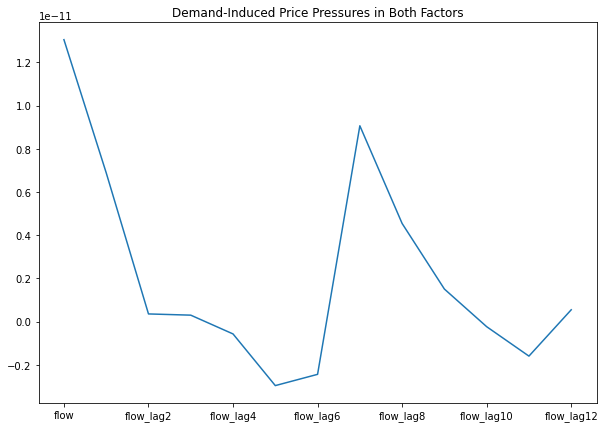

In [16]:
xs = ['flow'] + ['flow_lag%s' % i for i in range(1, 13)] # regressors
data = pd.read_parquet('table2_bothFactors.parquet')
res_ret = regression_res('ret ~ %s' % ' + '.join(xs), data, 'Cumulative Return Response', False)
res_ret.drop('Intercept').cumsum().plot(
    figsize = (10,7), 
    title = 'Demand-Induced Price Pressures in Both Factors'
)

# Replicate Figure 5 Panel (b)

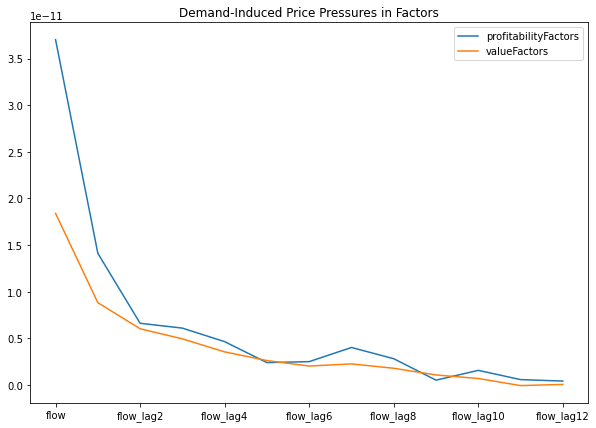

In [17]:
xs = ['flow'] + ['flow_lag%s' % i for i in range(1, 13)] # regressors
data = pd.read_parquet('table2_profitabilityFactors.parquet')
res_ret_profitabilityFactors = regression_res('ret ~ %s' % ' + '.join(xs), data, 'profitabilityFactors', False)
data = pd.read_parquet('table2_valueFactors.parquet')
res_ret_valueFactors = regression_res('ret ~ %s' % ' + '.join(xs), data, 'valueFactors', False)

pd.concat(
    [res_ret_profitabilityFactors.drop('Intercept'), 
     res_ret_valueFactors.drop('Intercept')
    ], axis=1
).cumsum().plot(
    y = ['profitabilityFactors', 'valueFactors'], 
    title = 'Demand-Induced Price Pressures in Factors', 
    figsize = (10,7)
)

# Replicate table 3

## Prepare template of query

In [23]:
query = """ select 
                date_time, tic, ret,
                avg(avg_flow) over (partition by tic order by date_time ASC rows BETWEEN %s PRECEDING AND current row) / 1000000000 as avg_flow
            from
                (select 
                    min(date_time) AS date_time, tic, 
                    sum(totalCapital / lag_totalCapital - 1) AS ret,
                    avg(money) as avg_flow
                FROM
                    (select
                        date_time,
                        tic,
                        totalCapital,
                        money,
                        LAG(totalCapital) over (PARTITION BY tic ORDER BY date_time ASC) AS lag_totalCapital,
                        %s
                    from 7035_prj.sz_trading_data
                    ) a
                WHERE %s
                group by year(date_time), quarter(date_time), tic
                ) b """

## Query database

In [24]:
past_quarterss = [4, 8]
for past_quarters in past_quarterss:
    # Both factors
    deciles = """ CEILING(ROW_NUMBER() OVER (PARTITION BY YEAR(`date_time`), quarter(`date_time`) ORDER BY pb asc) / COUNT(*) OVER (PARTITION BY YEAR(`date_time`), quarter(`date_time`)) * 10) AS value_decile,
                  CEILING(ROW_NUMBER() OVER (PARTITION BY YEAR(`date_time`), quarter(`date_time`) ORDER BY pe_ttm / ps asc) / COUNT(*) OVER (PARTITION BY YEAR(`date_time`), quarter(`date_time`)) * 10) AS profitability_decile """
    filters = """ value_decile = 10 and profitability_decile = 10 """
    df = mysql_query(query % (past_quarters - 1, deciles, filters),
                     user=user,
                     password=password,
                     port=3306)
    df.to_parquet('table3_bothFactors_past%sQuarters.parquet' % past_quarters)
    
    # Value Factor
    deciles = """ CEILING(ROW_NUMBER() OVER (PARTITION BY YEAR(`date_time`), quarter(`date_time`) ORDER BY pb asc) / COUNT(*) OVER (PARTITION BY YEAR(`date_time`), quarter(`date_time`)) * 10) AS value_decile """
    filters = """ value_decile = 10 """
    df = mysql_query(query % (past_quarters - 1, deciles, filters),
                     user=user,
                     password=password,
                     port=3306)
    df.to_parquet('table3_valueFactor_past%sQuarters.parquet' % past_quarters)
    
    # Profitability factor
    deciles = """ CEILING(ROW_NUMBER() OVER (PARTITION BY YEAR(`date_time`), quarter(`date_time`) ORDER BY pe_ttm / ps asc) / COUNT(*) OVER (PARTITION BY YEAR(`date_time`), quarter(`date_time`)) * 10) AS profitability_decile """
    filters = """ profitability_decile = 10 """
    df = mysql_query(query % (past_quarters - 1, deciles, filters),
                     user=user,
                     password=password,
                     port=3306)
    df.to_parquet('table3_profitabilityFactor_past%sQuarters.parquet' % past_quarters)

Elapsed time: 410.5499892234802 seconds
Elapsed time: 231.60412669181824 seconds
Elapsed time: 244.33944988250732 seconds
Elapsed time: 418.3050847053528 seconds
Elapsed time: 224.7240092754364 seconds
Elapsed time: 234.97468638420105 seconds


## Regression

In [25]:
files = os.listdir('.')
df_res = None
for file in files:
    if file[:7] == 'table3_' and file[-8:] == '.parquet':
        data = pd.read_parquet(file)
        res = regression_res('ret ~ avg_flow', data, 'Flow_%s' % file.split('_')[-1].split('.')[0])
        res = res.to_frame()
        res.columns = pd.MultiIndex.from_tuples([(file.split('_')[1], 'Flow_%s' % file.split('_')[-1].split('.')[0])])

        if df_res is None:
            df_res = res
        else:
            df_res = pd.concat([df_res, res], axis=1)

In [26]:
plot_df(df_res, 'Table 3')

# Replicate table 4

In [36]:
query = """ select
                *
            from
                (select
                    date_time, tic, turnoverRatio as `trade`,
                    ret_day,
                    (1 + ret_close) / (1 + ret_day) as ret_night,
                    flow,
                    lag(flow, 1) over (partition by tic order by date_time asc) as flow_lag1,
                    lag(flow, 2) over (partition by tic order by date_time asc) as flow_lag2,
                    lag(flow, 3) over (partition by tic order by date_time asc) as flow_lag3,
                    lag(flow, 4) over (partition by tic order by date_time asc) as flow_lag4,
                    lag(flow, 5) over (partition by tic order by date_time asc) as flow_lag5,
                    lag(flow, 6) over (partition by tic order by date_time asc) as flow_lag6,
                    lag(flow, 7) over (partition by tic order by date_time asc) as flow_lag7,
                    lag(flow, 8) over (partition by tic order by date_time asc) as flow_lag8,
                    lag(flow, 9) over (partition by tic order by date_time asc) as flow_lag9,
                    lag(flow, 10) over (partition by tic order by date_time asc) as flow_lag10,
                    lag(flow, 11) over (partition by tic order by date_time asc) as flow_lag11,
                    lag(flow, 12) over (partition by tic order by date_time asc) as flow_lag12
                from
                    (select
                        date_time, tic, turnoverRatio, money as flow,
                        `close` / LAG(`close`) over (partition by `tic` order by date_time asc) as ret_close,
                        `close` / `open` - 1 as ret_day
                    from 7035_prj.sz_trading_data
                    ) a
                WHERE ret_close IS NOT null
                ) b
            where flow_lag1 is not null and flow_lag2 is not null and flow_lag3 is not null and flow_lag4 is not null and flow_lag5 is not null and flow_lag6 is not null and flow_lag7 is not null and flow_lag8 is not null and flow_lag9 is not null and flow_lag10 is not null and flow_lag11 is not null and flow_lag12 IS NOT null
            """
df = mysql_query(query,user=user,password=password,port=3306)
df.to_parquet('table4_panelA.parquet')

Elapsed time: 3995.3164207935333 seconds


In [37]:
df.head()

,date_time,tic,trade,ret_day,ret_night,flow,flow_lag1,flow_lag2,flow_lag3,flow_lag4,flow_lag5,flow_lag6,flow_lag7,flow_lag8,flow_lag9,flow_lag10,flow_lag11,flow_lag12
0,2015-01-19,000001_SZ\r,2.17260,-0.012848,1.924531,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09,3.453450e+09,4.565390e+09,3.760220e+09,3.637480e+09
1,2015-01-20,000001_SZ\r,1.51577,0.000000,2.000000,2.064280e+09,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09,3.453450e+09,4.565390e+09,3.760220e+09
2,2015-01-21,000001_SZ\r,1.97274,0.038905,1.966167,2.758190e+09,2.064280e+09,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09,3.453450e+09,4.565390e+09
3,2015-01-22,000001_SZ\r,1.27585,-0.002789,1.997249,1.801440e+09,2.758190e+09,2.064280e+09,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09,3.453450e+09
4,2015-01-23,000001_SZ\r,1.48340,0.002786,2.001418,2.108750e+09,1.801440e+09,2.758190e+09,2.064280e+09,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09


## Replicate table 4 panel A

In [38]:
data = pd.read_parquet('table4_panelA.parquet').dropna()
data['diff'] = (data['ret_day'] - data['ret_night']).abs()

In [39]:
plot_df(pd.concat([regression_res('ret_day ~ trade', data, 'ret_day'), 
                   regression_res('ret_night ~ trade', data, 'ret_night'),
                   regression_res('diff ~ trade', data, 'difference')],
                  axis=1),
        'Table 4 Panel A')

,ret_day,ret_night,difference
Intercept,-1.07e-03***(2.51e-05),2.00e+00***(3.27e-05),2.00e+00***(5.57e-05)
trade,9.18e-04***(9.14e-06),-8.68e-04***(1.21e-05),-1.79e-03***(2.04e-05)
num of obs,2256317,2256317,2256317
adj. R sq.,0.017058,0.010474,0.014283


## Replicate table 4 panel B

In [7]:
data = pd.read_parquet('table4_panelA.parquet')
df_res = pd.DataFrame(columns = ['Day Ret', 'Night Ret', 'Difference'])
break_pts = [datetime.date(2018,1,1)]
intervals = [data['date_time'].min()] + break_pts + [data['date_time'].max()]
for i in range(len(intervals) - 1):
    data_ = data[data['date_time']
                 .between(intervals[i], 
                          intervals[i+1], 
                          inclusive = 'left')
                ].copy()
    data_.loc[:, 'diff'] = (data_.loc[:, 'ret_day'] - data_.loc[:, 'ret_night']).abs()
    day_ret = regression_res('ret_day ~ trade', 
                             data_,
                             'ret_day')
    night_ret = regression_res('ret_night ~ trade', 
                               data_,
                               'ret_night')
    diff_ret = regression_res('diff ~ trade', 
                              data_,
                              'difference')
    df_res.loc['%s ~ %s' % (intervals[i].year, intervals[i+1].year)] = [day_ret['trade'], night_ret['trade'], diff_ret['trade']]
plot_df(df_res, 'Table 4 Panel B')

,Day Ret,Night Ret,Difference
2015 ~ 2018,9.85e-04***(1.45e-05),-1.01e-03***(2.02e-05),-1.99e-03***(3.31e-05)
2018 ~ 2023,8.75e-04***(1.18e-05),-7.76e-04***(1.50e-05),-1.65e-03***(2.60e-05)


# Replicate Figure 1 Panel (b)

In [8]:
data.head()

,date_time,tic,trade,ret_day,ret_night,flow,flow_lag1,flow_lag2,flow_lag3,flow_lag4,flow_lag5,flow_lag6,flow_lag7,flow_lag8,flow_lag9,flow_lag10,flow_lag11,flow_lag12
0,2015-01-19,000001_SZ\r,2.17260,-0.012848,1.924531,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09,3.453450e+09,4.565390e+09,3.760220e+09,3.637480e+09
1,2015-01-20,000001_SZ\r,1.51577,0.000000,2.000000,2.064280e+09,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09,3.453450e+09,4.565390e+09,3.760220e+09
2,2015-01-21,000001_SZ\r,1.97274,0.038905,1.966167,2.758190e+09,2.064280e+09,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09,3.453450e+09,4.565390e+09
3,2015-01-22,000001_SZ\r,1.27585,-0.002789,1.997249,1.801440e+09,2.758190e+09,2.064280e+09,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09,3.453450e+09
4,2015-01-23,000001_SZ\r,1.48340,0.002786,2.001418,2.108750e+09,1.801440e+09,2.758190e+09,2.064280e+09,3.016200e+09,2.403350e+09,1.868800e+09,1.889300e+09,1.204990e+09,2.293100e+09,3.835380e+09,2.128000e+09,2.634800e+09


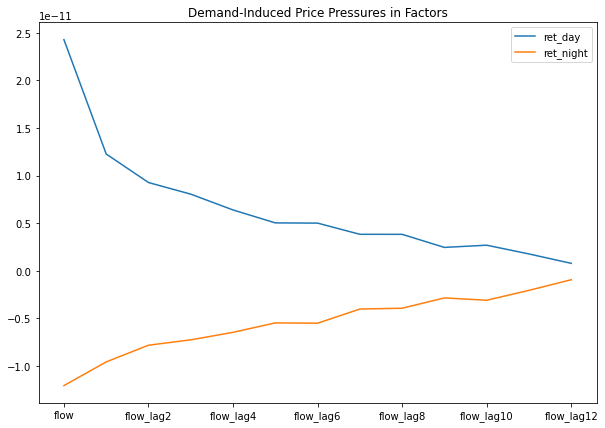

In [9]:
xs = ['flow'] + ['flow_lag%s' % i for i in range(1, 13)] # regressors
res_day = regression_res('ret_day ~ %s' % ' + '.join(xs), data, 'ret_day', False)
res_night = regression_res('ret_night ~ %s' % ' + '.join(xs), data, 'ret_night', False)
pd.concat([res_day.drop('Intercept'), res_night.drop('Intercept')], axis=1).cumsum().plot(y=['ret_day', 'ret_night'], title = 'Demand-Induced Price Pressures in Factors', figsize = (10,7))

# Replicate Figure 4

In [74]:
query = """
select
    min(`date_time`) AS `date_time`, sum(`ret`) as `ret`, sum(`flow`) as `flow`
from
    (SELECT 
        date_time, tic, 
        totalCapital / lag_totalCapital - 1 AS `ret`,
        money as flow
    FROM 
        (SELECT date_time, tic, money, totalCapital, LAG(totalCapital) over (PARTITION BY tic ORDER BY date_time asc) AS lag_totalCapital,
         %s
         FROM 7035_prj.sz_trading_data
        ) a
    where lag_totalCapital is not null and %s
    ) b
group by year(`date_time`), month(`date_time`)
ORDER BY `date_time`
"""

In [75]:
deciles = """ CEILING(ROW_NUMBER() OVER (PARTITION BY year(`date_time`), month(`date_time`) ORDER BY pb asc) / COUNT(*) OVER (PARTITION BY year(`date_time`), month(`date_time`)) * 10) AS value_decile """
filters = """ value_decile = 10 """
df = mysql_query(query % (deciles, filters),
                 user=user,
                 password=password,
                 port=3306)
df.to_parquet('figure4_valueFactors.parquet')

Elapsed time: 291.4115376472473 seconds


In [76]:
deciles = """ CEILING(ROW_NUMBER() OVER (PARTITION BY year(`date_time`), month(`date_time`) ORDER BY pe_ttm / ps asc) / COUNT(*) OVER (PARTITION BY year(`date_time`), month(`date_time`)) * 10) AS profitability_decile """
filters = """ profitability_decile = 10 """
df = mysql_query(query % (deciles, filters),
                 user=user,
                 password=password,
                 port=3306)
df.to_parquet('figure4_profitabilityFactors.parquet')

Elapsed time: 341.9109253883362 seconds


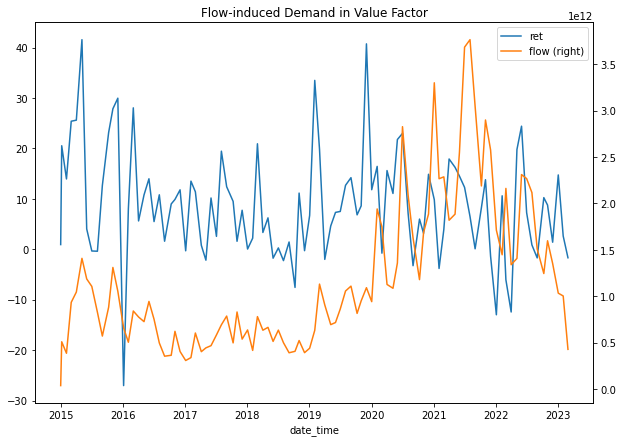

In [77]:
data_valueFactor = pd.read_parquet('figure4_valueFactors.parquet')
fig, ax = plt.subplots(figsize=(10,7)) 
data_valueFactor.plot(x = 'date_time', y = 'ret', kind = 'line', ax = ax, title = 'Flow-induced Demand in Value Factor')
data_valueFactor.plot(x = 'date_time', y = 'flow', kind = 'line', ax = ax, secondary_y = True) 

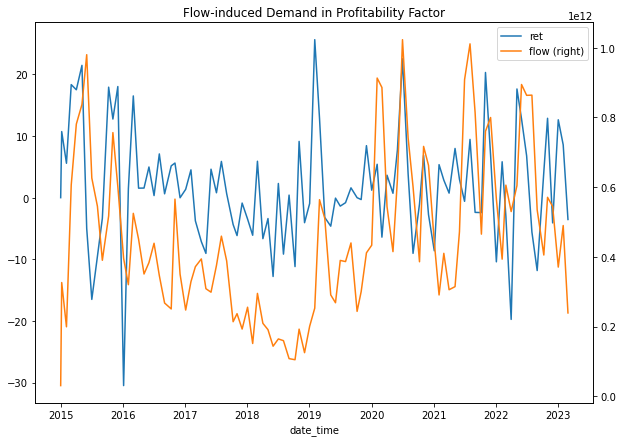

In [78]:
data_profitabilityFactor = pd.read_parquet('figure4_profitabilityFactors.parquet')
fig, ax = plt.subplots(figsize=(10,7)) 
data_profitabilityFactor.plot(x = 'date_time', y = 'ret', kind = 'line', ax = ax, title = 'Flow-induced Demand in Profitability Factor')
data_profitabilityFactor.plot(x = 'date_time', y = 'flow', kind = 'line', ax = ax, secondary_y = True) 

# Extension: Hedge value factor and profitability factor portfolios with flow factor portfolio

## Compute monthly return of profitability factor, value factor and flow factor portfolios.

In [56]:
table = """
select 
    min(date_time) AS date_time, sum(%s) AS %s
from
    (select
        date_time, tic, %s,
        CEILING(ROW_NUMBER() OVER (PARTITION BY year(`date_time`), month(`date_time`) ORDER BY lag_%s asc) / COUNT(*) OVER (PARTITION BY year(`date_time`), month(`date_time`)) * 10) AS %s
    from
        (select
            date_time, tic, %s,
            lag(%s) over (partition by tic order by date_time asc) as lag_%s
        from 
            (select
                MIN(`date_time`) AS `date_time`, tic,
                sum(ret) as %s,
                avg(%s) as %s
            from
                (select
                    date_time, tic, %s,
                    totalCapital / lag_totalCapital - 1 as ret
                from
                    (select
                        date_time, tic,
                        totalCapital, %s,
                        LAG(totalCapital) over (PARTITION BY tic ORDER BY date_time asc) AS lag_totalCapital
                    from 7035_prj.sz_trading_data
                    ) a%s
                ) b%s
            group BY YEAR(`date_time`), MONTH(`date_time`), tic
            ORDER BY `date_time`
            ) c%s
        ) d%s
    ) e%s
where %s = 10
GROUP BY YEAR(date_time), MONTH(date_time)
"""

query = """
select
    f1.date_time, ret_value, ret_profitability, ret_flow
from
    (%s) f1
    inner join
    (%s) f2
    on (year(f1.date_time) = year(f2.date_time) and month(f1.date_time) = month(f2.date_time))
    inner join
    (%s) f3
    on (year(f3.date_time) = year(f2.date_time) and month(f3.date_time) = month(f2.date_time))
"""

ret_name = ['ret_value', 'ret_profitability', 'ret_flow']
num = [1,2,3]
indicator = ['pb', 'pe_ttm, ps', 'money']
indicator_cal = ['pb', 'pe_ttm / ps', 'money']
indicator_avg = ['avg_pb', 'avg_profitability', 'avg_flow']
decile = ['value_decile', 'profitability_decile', 'flow_decile']

df = mysql_query(query % tuple(table % (ret_name[i], ret_name[i], ret_name[i], indicator_avg[i], decile[i], ret_name[i], indicator_avg[i], indicator_avg[i], ret_name[i], indicator_cal[i], indicator_avg[i], indicator[i], indicator[i], num[i], num[i], num[i], num[i], num[i], decile[i]) for i in range(3)),
                 user=user,
                 password=password,
                 port=3306)
df.to_parquet('extension_ret.parquet')

Elapsed time: 639.3040981292725 seconds


In [114]:
df = pd.read_parquet('extension_ret.parquet')

# Find combination between profitability & value factor and flow factor portfolios such that fluctuation of return is the least.

In [115]:
from scipy.optimize import minimize

# objective function
def objective(x, factor):
    return (x[0] * df['ret_flow'] + x[1] * df[factor]).std()

# constraint function
def constr(x):
    return (x[0] + x[1] - 1)

def return_to_risk(df):
    return df.mean() / df.std()

# Number of unit(s) of flow factor portfolio to long/short if 1 unit of factor portfolio is longed.
def optimize(factor):
    cons = {'type':'eq', 'fun': constr}
    result = minimize(lambda x: objective(x, factor), [-1, 1], method='SLSQP', constraints=cons)
    print('Status : %s' % result['message'])
    print('Total Evaluations: %d' % result['nfev'])
    # evaluate solution
    solution = result['x']
    evaluation = objective(solution, factor)
    print('Solution: f(%s) = %.5f' % (solution, evaluation))
    return solution

In [116]:
w_flow, w_value = optimize('ret_value')
df.loc[:, 'ret_flow_value_combine'] = (
    w_flow * df['ret_flow'] + w_value * df['ret_value']
)

w_flow, w_profitability = optimize('ret_profitability')
df.loc[:, 'ret_flow_profitability_combine'] = (
    w_flow * df['ret_flow'] + w_profitability * df['ret_profitability']
)

Status : Optimization terminated successfully
Total Evaluations: 24
Solution: f([0.91012997 0.08987003]) = 9.25028
Status : Optimization terminated successfully
Total Evaluations: 23
Solution: f([0.45295336 0.54704664]) = 8.78897


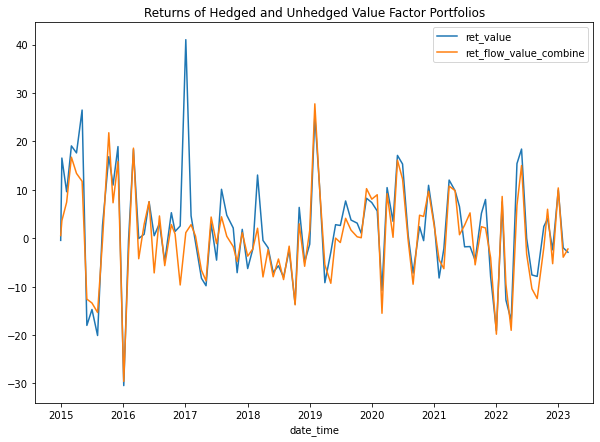

In [117]:
df.plot(x = 'date_time', 
        y = ['ret_value', 'ret_flow_value_combine'], 
        figsize = (10,7), 
        title = 'Returns of Hedged and Unhedged Value Factor Portfolios'
       )

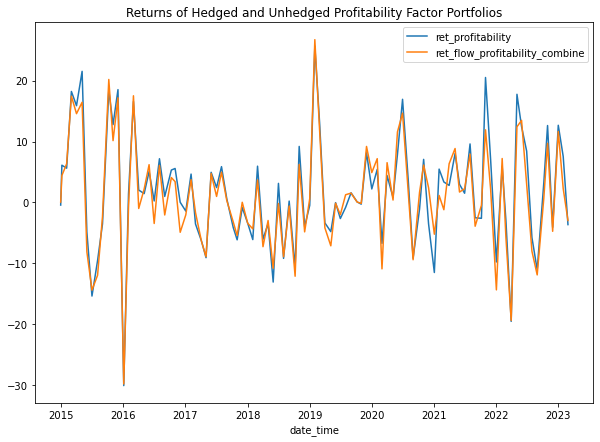

In [118]:
df.plot(x = 'date_time', 
        y = ['ret_profitability', 'ret_flow_profitability_combine'], 
        figsize = (10,7), 
        title = 'Returns of Hedged and Unhedged Profitability Factor Portfolios'
       )

## Compare return-to-risk ratio before and after hedging.

In [121]:
pd.DataFrame(
    [
        [return_to_risk(df.loc[:, 'ret_value']), return_to_risk(df.loc[:, 'ret_flow_value_combine'])],
        [return_to_risk(df.loc[:, 'ret_profitability']), return_to_risk(df.loc[:, 'ret_flow_profitability_combine'])]
    ],
    columns = ['Before hedging', 'After hedging'],
    index = ['value', 'profitability']
).rename_axis(
    index = 'factors'
)

,Before hedging,After hedging
factors,,
value,0.190444,0.040643
profitability,0.199494,0.124103
